## 导入	
* 脚本整理 cytoscape 输出和 loop 类别的绘图
* node weight (name weight)
* node interaction (source	target	interaction	directed	symbol	value)

In [2]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
import hicstraw
import itertools
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.ttflist.append(font_manager.FontProperties(fname='/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf'))
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
RNA=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt",sep='\t')


In [4]:
NPC=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/cytoscape/NPC/NPC_Eweights_bash.bed',sep='\t')
NPC=NPC.sort_values(by=['chr','start','end'], key=lambda col: col if col.name == 'chr' else pd.to_numeric(col))

## cytoscape 	
* loop weights	
* Eweights

### 添加 loop weight（HiC matrix）	
* 输入：loop, gene, enhancer overlap	
* 输出：loop weights

In [ ]:
name='NPC'
GBM=pd.read_csv(f'/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/merge/filtered_{name}_chip.bedpe',sep='\t',header=None)
GBM.columns=['chr1','start1','end1','chr2','start2','end2','chr_g','start_g','end_g','gene','chr_e','start_e','end_e','samples','occurrences','unknown']

In [4]:
GBMmatrix=cooler.Cooler(f'/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/10000/{name}_merge_10000.cool')
# GBM 不用_merge_ 

In [5]:
from joblib import Parallel, delayed
# 没有flanking region
def fetch_contacts(row,bala=False):
    matrix = GBMmatrix.matrix(balance=bala).fetch(
        f'{row["chr1"]}:{row["start1"]}-{row["end1"]}',
        f'{row["chr2"]}:{row["start2"]}-{row["end2"]}'
    )
    if matrix.size == 1:
        return matrix.item()  # 返回标量值
    elif matrix.size == 0:
        return None  # 空数组返回 None
    else:
        print(f'Warning: {row["loopid"]} has more than one value')
        return matrix.mean()  

In [7]:

GBM['loopid'] = GBM['chr1'] + ':' + GBM['start1'].astype(str) + '-' + GBM['end1'].astype(str) + '_' + GBM['chr2'] + ':' + GBM['start2'].astype(str) + '-' + GBM['end2'].astype(str)
GBM_loop=GBM.loc[:,['loopid','chr1','start1','end1','chr2','start2','end2']].drop_duplicates()

In [ ]:
notna_indices = GBM_loop['loopid'].notna()
GBM_loop.loc[notna_indices, 'ICEcontact'] = Parallel(n_jobs=-1)(
    delayed(fetch_contacts)(row,bala=True) for _, row in GBM_loop.loc[notna_indices].iterrows()
)
# GBM_loop.loc[notna_indices, 'rawcontact'] = Parallel(n_jobs=-1)(
#     delayed(fetch_contacts)(row,bala=False) for _, row in GBM_loop.loc[notna_indices].iterrows()
# )
GBM_loop.to_csv(f'{name}_loop.txt',sep='\t',index=False)

In [9]:
GBM_loop=pd.read_csv(f'{name}/{name}_loop.txt',sep='\t')
GBM=pd.merge(GBM,GBM_loop[['loopid','rawcontact','ICEcontact']],on='loopid')
GBM.drop(columns=['loopid'],inplace=True)

### 确定enhancer节点 
* 输入：loop 和 Enhancer 的互作  
* 根据 bedtools 结果挑选enhancer节点

In [ ]:
fil1 = (GBM['chr1'] == GBM['chr_e']) & (GBM['start1'] <= GBM['end_e']) & (GBM['end1'] >= GBM['start_e'])
fil2 = (GBM['chr2'] == GBM['chr_e']) & (GBM['start2'] <= GBM['end_e']) & (GBM['end2'] >= GBM['start_e'])

GBM.loc[:,'ebin']=np.nan
GBM['ebin'] = GBM['ebin'].astype('object')
GBM.loc[fil1, 'ebin'] = GBM.loc[fil1, ['chr1', 'start1', 'end1']].astype(str).agg('_'.join, axis=1)
GBM.loc[fil2, 'ebin'] = GBM.loc[fil2, ['chr2', 'start2', 'end2']].astype(str).agg('_'.join, axis=1)
# GBM.loc[:,'eid'] = GBM.loc[:, ['chr_e', 'start_e', 'end_e']].astype(str).agg('_'.join, axis=1)

### 节点矩阵和互作矩阵

In [ ]:
# 01 构建Eweights矩阵
# ！！！ 有问题如果一个ebin 有三个enhancer，occurrences是29，3，3，则3会被去掉，所以添加了eid
# loop中会有重复的E-G作用
Eweights=GBM[['chr_e','start_e','end_e','ebin','occurrences','eid']].drop_duplicates().groupby('ebin')['occurrences'].sum().reset_index()
Eweights['weights'] = np.log2(Eweights['occurrences'] + 1).transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
# 保存 Eweights bed文件
Eweights[['chr','start','end']]=Eweights['ebin'].str.split('_',expand=True)
Eweights.rename(columns={'occurrences': 'weights'}, inplace=True)
Eweights=Eweights.loc[:,['chr','start','end','weights','ebin']]
# Eweights.to_csv('Eweights.bed',sep='\t',index=False)

In [ ]:
# 02 构建RNA表达矩阵
Gweights=GBM[['gene']].drop_duplicates()
Gweights=pd.merge(Gweights,RNA[['Gene',name]],left_on='gene',right_on='Gene',how='left')
Gweights.drop(columns=['Gene'],inplace=True)
Gweights['weights'] = np.log2(Gweights[name] + 1).transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
# 03 构建节点矩阵
# 合并Gweights和Eweights
Nweights = pd.concat([Gweights[['gene', 'weights']], Eweights[['ebin', 'weights']].rename(columns={'ebin': 'gene'})])
Nweights.columns=['node','weights']

In [ ]:
# 04 构建 E-P 互作矩阵
# 互作权重 基因 ebin
GRN=GBM.loc[:,['gene','ebin','rawcontact','ICEcontact']].drop_duplicates()

# interaction	directed	symbol
GRN['interaction'] = 'dd'
GRN['directed'] = 'TRUE'
GRN['symbol'] = [str(x) for x in range(1, GRN.shape[0] + 1)]
GRN=GRN.loc[:,['ebin','gene','interaction','directed','symbol','rawcontact','ICEcontact']]
GRN.columns=['node1','node2','interaction','directed','symbol','rawcontact','ICEcontact']

In [19]:
GRN.to_csv(f'{name}/GRN.txt',sep='\t',index=False)
Eweights.to_csv(f'{name}/Eweights.txt',sep='\t',index=False)
Gweights.to_csv(f'{name}/Gweights.txt',sep='\t',index=False)
Nweights.to_csv(f'{name}/Nweights.txt',sep='\t',index=False)
GBM.to_csv(f'{name}/{name}.txt',sep='\t',index=False)


### 数据展示

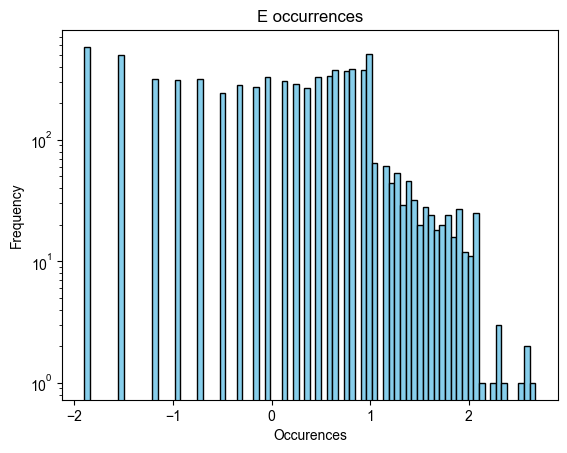

In [ ]:
# E weights的分布
plt.hist(Eweights['weights'], bins=80, color='skyblue', edgecolor='black')  # bins为分组数
plt.yscale('log')
plt.title('E occurrences')  # 图标题
plt.xlabel('Occurences')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
plt.show()

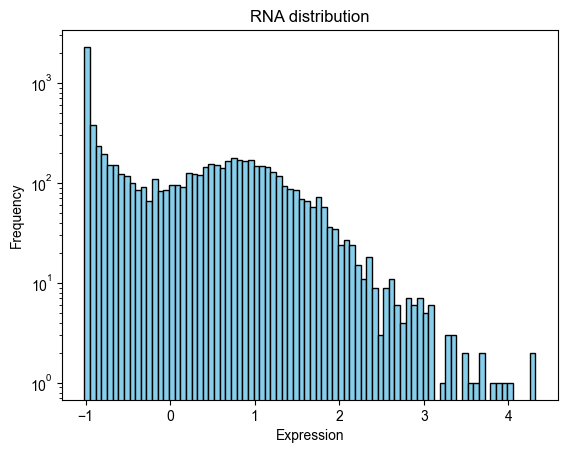

In [ ]:
# Gene weights
plt.hist(Gweights['weights'], bins=80, color='skyblue', edgecolor='black')  # bins为分组数
plt.yscale('log')
plt.title('RNA distribution')  # 图标题
plt.xlabel('Expression')  # X轴标签
plt.ylabel('Frequency')  # Y轴标签
plt.show()

## 鉴定 ebin gbin
* Enhancer 数量 
* E-P P-P other 数量    
* 各种 E-P 的基因表达


In [3]:
EP=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/cytoscape/loop_anno.bedpe',sep='\t',header=None)
EP.columns=['chr1','start1','end1','chr2','start2','end2','cloop','chr_g','start_g','end_g','ensembl','symbol','type','chr_e','start_e','end_e','samples','occurrences']

In [ ]:
# get E-G pairs
# ebin 是 Enhancer 所在的loop anchor key，ebin_id 是 Enhancer 所在的loop anchor number
# 问题：一个 ebin_id 可能有两个 anchor number，会覆盖
#  
fil1 = (EP['chr1'] == EP['chr_e']) & (EP['start1'] <= EP['end_e']) & (EP['end1'] >= EP['start_e'])
fil2 = (EP['chr2'] == EP['chr_e']) & (EP['start2'] <= EP['end_e']) & (EP['end2'] >= EP['start_e'])
EP.loc[:,'ebin']=np.nan
EP['ebin'] = EP['ebin'].astype('object')
EP['ebin_id'] = np.nan
EP['ebin_id'] = EP['ebin_id'].astype('object')
EP.loc[fil1, 'ebin'] = EP.loc[fil1, ['chr1', 'start1', 'end1']].astype(str).agg('_'.join, axis=1)
EP.loc[fil1,'ebin_id']=1
EP.loc[fil2, 'ebin'] = EP.loc[fil2, ['chr2', 'start2', 'end2']].astype(str).agg('_'.join, axis=1)
EP.loc[fil2,'ebin_id']=2

In [5]:
# gene
fil1 = (EP['chr1'] == EP['chr_g']) & (EP['start1'] <= EP['start_g']) & (EP['end1'] >= EP['end_g'])
fil2 = (EP['chr2'] == EP['chr_g']) & (EP['start2'] <= EP['start_g']) & (EP['end2'] >= EP['end_g'])
EP.loc[:,'gbin_id']=np.nan
EP['gbin_id'] = EP['gbin_id'].astype('object')
EP.loc[fil1,'gbin_id']=1
EP.loc[fil2,'gbin_id']=2

## 分类loop并给基因分类

In [ ]:
# 'chr1','start1','end1','chr2','start2','end2','cloop','symbol','type','occurrences'
EPs=EP.drop(columns=['ensembl','samples','chr_g','start_g','end_g','chr_e','start_e','end_e'])
EPs['Eweights'] = EPs.groupby('ebin')['occurrences'].transform('sum')
EPss=EPs.drop(columns=['occurrences']).drop_duplicates()

In [ ]:

EPss['loopid']=EPss['chr1'] + ':' + (EPss['start1']+10000).astype(str) + '-' + (EPss['end1']-10000).astype(str) + '_' + EPss['chr2'] + ':' + (EPss['start2']+10000).astype(str) + '-' + (EPss['end2']-10000).astype(str)
EPs['loopid']=EPs['chr1'] + ':' + (EPs['start1']+10000).astype(str) + '-' + (EPs['end1']-10000).astype(str) + '_' + EPs['chr2'] + ':' + (EPs['start2']+10000).astype(str) + '-' + (EPs['end2']-10000).astype(str)
EP['loopid']=EP['chr1'] + ':' + (EP['start1']+10000).astype(str) + '-' + (EP['end1']-10000).astype(str) + '_' + EP['chr2'] + ':' + (EP['start2']+10000).astype(str) + '-' + (EP['end2']-10000).astype(str)

In [10]:
# EP.loc[EP['loopid']=='chrY:6950000-6980000_chrY:7860000-7890000',:]
EP.loc[EP['loopid']=='chrY:6960000-6970000_chrY:7870000-7880000',:]

,chr1,start1,end1,chr2,start2,end2,cloop,chr_g,start_g,end_g,...,type,chr_e,start_e,end_e,samples,occurrences,ebin,ebin_id,gbin_id,loopid
110212,chrY,6950000,6980000,chrY,7860000,7890000,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY:6960000-6970000_chrY:7870000-7880000


In [ ]:
# 01 查看Enhancer

# 计算每个ebin分组中Eweights的唯一值数量
unique_counts = EPs.groupby('ebin')['Eweights'].nunique()

# 检查是否有分组的Eweights不是唯一的
if (unique_counts > 1).any():
    print("同一Ebin的Eweights不相同的情况")
else:
    print("同一Ebin的Eweights都是相同的")

所有同一组的Eweights都是相同的


In [ ]:
# 02 查看基因

# 存在同一个loop，两端是不同的基因
EPss.groupby('loopid')['gbin_id'].nunique().value_counts()

gbin_id
1    8472
2    5089
0    4866
Name: count, dtype: int64

In [ ]:
# 看看gene全都是NA的loop anchor

all_na_groups = EPss.groupby('loopid')['gbin_id'].apply(lambda x: x.isna().all())
num_all_na_groups = all_na_groups.sum()

print(num_all_na_groups)
# 4866

4866


In [13]:
# 看看一个 loopid 里有两个基因ID的loop
unique_counts = EPss.groupby('loopid')['gbin_id'].nunique()
# 同一个loop有两个基因ID的loop
difuni = unique_counts[unique_counts == 2].index

EPss.loc[EPss['loopid'].isin(difuni),:]

,chr1,start1,end1,chr2,start2,end2,cloop,symbol,type,ebin,ebin_id,gbin_id,Eweights,loopid
34,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
38,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
40,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
44,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
46,chr1,6230000,6260000,chr1,6420000,6450000,3,HES3,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110256,chrY,19720000,19750000,chrY,20560000,20590000,3,KDM5DP1,processed_pseudogene,chrY_20560000_20590000,2.0,2.0,44.0,chrY:19730000-19740000_chrY:20570000-20580000
110257,chrY,19720000,19750000,chrY,20560000,20590000,3,TTTY10,lncRNA,chrY_19720000_19750000,1.0,2.0,25.0,chrY:19730000-19740000_chrY:20570000-20580000
110258,chrY,19720000,19750000,chrY,20560000,20590000,3,TTTY10,lncRNA,chrY_20560000_20590000,2.0,2.0,44.0,chrY:19730000-19740000_chrY:20570000-20580000
110259,chrY,19720000,19750000,chrY,20560000,20590000,3,EIF1AY,protein_coding,chrY_19720000_19750000,1.0,2.0,25.0,chrY:19730000-19740000_chrY:20570000-20580000


### 方法一	
* E-P 有问题

In [14]:
EPss['looptype']=np.nan
EPss['looptype'] = EPss['looptype'].astype('object')
# E-P loop
EPss.loc[EPss['gbin_id'].notna() & EPss['ebin_id'].notna() & EPss['gbin_id']!=EPss['ebin_id'],'looptype']='E-P'
# EPss

In [15]:
EPss['looptype'].value_counts()

looptype
E-P    35099
Name: count, dtype: int64

In [15]:


def analyze_loop_interactions(df):
    """
    分析loop中的真实相互作用关系
    
    Parameters:
    df: DataFrame, 包含以下列:
        - loopid: loop的唯一标识符
        - enhancer_pos: Enhancer在loopanchor的位置 (1, 2)
        - gene_pos: 基因在loopanchor的位置 (1, 2)
    
    Returns:
    DataFrame: 包含每个loop的完整互作信息
    """
    # 创建一个字典来存储每个loop的信息
    loop_info = {}
    
    for _, row in df.iterrows():
        loopid = row['loopid']
        # 初始化loop信息
        if loopid not in loop_info:
            loop_info[loopid] = {
                'ebin_id': set(),
                'gbin_id': set()
            }
        e_pos = row['ebin_id']
        g_pos = row['gbin_id']
        
        # 添加位置信息
        if not pd.isna(e_pos):
            loop_info[loopid]['ebin_id'].add(str(e_pos))
        if not pd.isna(g_pos):
            loop_info[loopid]['gbin_id'].add(str(g_pos))
    
    # 分析每个loop的类型
    results = []
    for loopid, info in loop_info.items():
        enhancers = info['ebin_id']
        genes = info['gbin_id']
        
        # 确定loop类型
        is_ep = False
        is_pp = False
        is_ee = False
        is_other = False
        
        # 检查E-P相互作用
        if enhancers and genes:
            # 如果enhancer和gene在loop的不同端，就是E-P
            if len(enhancers.intersection(genes)) < len(enhancers.union(genes)):
                is_ep = True
        
        # 检查P-P相互作用
        if len(genes) >= 2:
            is_pp = True
            
        # 检查E-E相互作用
        if len(enhancers) >= 2:
            is_ee = True
            
        # 如果都不是，标记为other
        if not any([is_ep, is_pp, is_ee]):
            is_other = True
            
        results.append({
            'loopid': loopid,
            'E-P': is_ep,
            'P-P': is_pp,
            'E-E': is_ee,
            'other': is_other,
            'ebin_id': ','.join(sorted(enhancers)),
            'gbin_id': ','.join(sorted(genes))
        })
    
    return pd.DataFrame(results)

def get_gene_loop_types(df, gene_column):
    """
    分析每个基因参与的loop类型
    
    Parameters:
    df: DataFrame, 包含loop分析结果和基因信息
    gene_column: 字符串，基因列的名称
    
    Returns:
    DataFrame: 包含每个基因参与的loop类型统计
    """
    # 创建基因-loop类型统计表
    unique_genes = df[gene_column].unique()
    
    stats = []
    for gene in unique_genes:
        gene_loops = df[df[gene_column] == gene]
        
        stat = {
            'gene': gene,
            'E-P_loops': gene_loops['E-P'].sum(),
            'P-P_loops': gene_loops['P-P'].sum(),
            'E-E_loops': gene_loops['E-E'].sum(),
            'other_loops': gene_loops['other'].sum(),
            'total_loops': len(gene_loops),
            'unique_interactions': len(gene_loops['loopid'].unique())
        }
        stats.append(stat)
    
    return pd.DataFrame(stats)



In [16]:

if __name__ == "__main__":
    df=EPss
    
    # 分析loop互作
    loop_analysis = analyze_loop_interactions(df)
    
    # 合并原始数据的基因信息
    gene_info = df[['loopid', 'symbol']].drop_duplicates()
    result_df = pd.merge(loop_analysis, gene_info, on='loopid')
    
    # 获取每个基因的统计信息
    gene_stats = get_gene_loop_types(result_df, 'symbol')
    

In [ ]:
# E-P 的判断有大问题
result_df.loc[result_df['symbol']=='ICMT-DT',:]

,loopid,E-P,P-P,E-E,other,ebin_id,gbin_id,symbol
14,chr1:6240000-6250000_chr1:6430000-6440000,False,True,True,False,"1.0,2.0","1.0,2.0",ICMT-DT


In [59]:
EPss.loc[EPss['loopid']=='chr1:6240000-6250000_chr1:6430000-6440000',:]

,chr1,start1,end1,chr2,start2,end2,cloop,symbol,type,ebin,ebin_id,gbin_id,Eweights,loopid
34,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
38,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT-DT,lncRNA,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
40,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
44,chr1,6230000,6260000,chr1,6420000,6450000,3,ICMT,protein_coding,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
46,chr1,6230000,6260000,chr1,6420000,6450000,3,HES3,protein_coding,chr1_6230000_6260000,1.0,1.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
50,chr1,6230000,6260000,chr1,6420000,6450000,3,HES3,protein_coding,chr1_6420000_6450000,2.0,1.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
52,chr1,6230000,6260000,chr1,6420000,6450000,3,HES2,protein_coding,chr1_6230000_6260000,1.0,2.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
56,chr1,6230000,6260000,chr1,6420000,6450000,3,HES2,protein_coding,chr1_6420000_6450000,2.0,2.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000
58,chr1,6230000,6260000,chr1,6420000,6450000,3,ESPN,protein_coding,chr1_6230000_6260000,1.0,2.0,245.0,chr1:6240000-6250000_chr1:6430000-6440000
62,chr1,6230000,6260000,chr1,6420000,6450000,3,ESPN,protein_coding,chr1_6420000_6450000,2.0,2.0,49.0,chr1:6240000-6250000_chr1:6430000-6440000


In [52]:
# 只保留那些处于两端的enhancer
result=pd.merge(result_df,EPss.loc[EPss['ebin_id']!=EPss['gbin_id'],['loopid','Eweights']].drop_duplicates(),on='loopid')

### 方法二	
* Eweights 计算有问题，全是0

In [18]:


def process_matrix(df):
    # 创建一个字典来存储bin_id和对应的信息
    bin_info = {}
    
    # 处理enhancer bins
    ebin_rows = df[['ebin_id', 'Eweights']].drop_duplicates()
    for _, row in ebin_rows.iterrows():
        bin_info[row['ebin_id']] = ('E', row['Eweights'])
    
    # 处理gene bins
    gbin_rows = df[['gbin_id', 'symbol']].drop_duplicates()
    for _, row in gbin_rows.iterrows():
        bin_info[row['gbin_id']] = (row['symbol'], None)
    
    # 创建所有可能的组合
    all_bins = list(bin_info.keys())
    all_combinations = list(itertools.combinations(all_bins, 2))
    
    # 准备新矩阵的数据
    new_data = []
    
    # 为每个loopid处理数据
    for loopid in df['loopid'].unique():
        loop_df = df[df['loopid'] == loopid]
        
        for bin1, bin2 in all_combinations:
            # 获取bin的信息
            bin1_info = bin_info[bin1]
            bin2_info = bin_info[bin2]
            
            # 设置默认值
            row_data = {
                'loopid': loopid,
                'bin1': bin1_info[0] if bin1_info[0] != 'E' else 'E',
                'bin2': bin2_info[0] if bin2_info[0] != 'E' else 'E',
                'Eweights': max(bin1_info[1] or 0, bin2_info[1] or 0),
                'E-P': 0,
                'P-P': 0,
                'E-E': 0,
                'other': 0
            }
            
            # 判断组合类型
            if bin1_info[0] == 'E' and bin2_info[0] != 'E':
                row_data['E-P'] = 1
            elif bin1_info[0] != 'E' and bin2_info[0] == 'E':
                row_data['E-P'] = 1
            elif bin1_info[0] == 'E' and bin2_info[0] == 'E':
                row_data['E-E'] = 1
            elif bin1_info[0] != 'E' and bin2_info[0] != 'E':
                row_data['P-P'] = 1
            else:
                row_data['other'] = 1
            
            new_data.append(row_data)
    
    # 创建新的DataFrame
    result_df = pd.DataFrame(new_data)
    
    return result_df


In [19]:
result2=process_matrix(EPss)

In [66]:
# 代码有问题，Eweights全是0
result2.loc[result2['Eweights']>0,:]

,loopid,bin1,bin2,Eweights,E-P,P-P,E-E,other


In [20]:
EPss.loc[EPss['loopid']=='chr1:2820000-2830000_chr1:3430000-3440000',:]

,chr1,start1,end1,chr2,start2,end2,cloop,symbol,type,ebin,ebin_id,gbin_id,Eweights,loopid
0,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000233234,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
1,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000233234,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000
3,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000287396,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
4,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000287396,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000
6,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000231630,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
7,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000231630,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000


### 方法三

In [ ]:


def process_matrix(df):
    # 创建一个嵌套字典来存储每个loop下的bin信息
    loop_bin_info = {}
    
    # 处理每个loop的数据
    for loopid in df['loopid'].unique():
        loop_df = df[df['loopid'] == loopid]
        
        # 存储该loop下所有的enhancer和gene信息
        enhancers = set()  # 存储enhancer bins
        genes = {}  # 存储gene bins和对应的gene names
        weights = {}  # 存储每个bin的weights
        
        # 处理enhancers
        for _, row in loop_df.iterrows():
            if pd.notna(row['ebin_id']):
                enhancers.add(row['ebin_id'])
                weights[row['ebin_id']] = row['Eweights']
            
            if pd.notna(row['gbin_id']):
                if row['gbin_id'] not in genes:
                    genes[row['gbin_id']] = set()
                genes[row['gbin_id']].add(row['symbol'])
                weights[row['gbin_id']] = row['Eweights']
        
        loop_bin_info[loopid] = {
            'enhancers': enhancers,
            'genes': genes,
            'weights': weights
        }
    
    # 准备新矩阵的数据
    new_data = []
    
    # 为每个loopid处理数据
    for loopid, info in loop_bin_info.items():
        enhancers = list(info['enhancers'])
        gene_bins = list(info['genes'].keys())
        
        # 1. 处理 E-P 相互作用
        for e_bin in enhancers:
            for g_bin in gene_bins:
                for gene_name in info['genes'][g_bin]:
                    new_data.append({
                        'loopid': loopid,
                        'bin1': 'E',
                        'bin2': gene_name,
                        'Eweights': max(info['weights'].get(e_bin, 0), info['weights'].get(g_bin, 0)),
                        'E-P': 1,
                        'P-P': 0,
                        'E-E': 0,
                        'other': 0
                    })
        
        # 2. 处理 P-P 相互作用
        if len(gene_bins) > 1:
            for (g_bin1, g_bin2) in itertools.combinations(gene_bins, 2):
                for gene1 in info['genes'][g_bin1]:
                    for gene2 in info['genes'][g_bin2]:
                        new_data.append({
                            'loopid': loopid,
                            'bin1': gene1,
                            'bin2': gene2,
                            'Eweights': max(info['weights'].get(g_bin1, 0), info['weights'].get(g_bin2, 0)),
                            'E-P': 0,
                            'P-P': 1,
                            'E-E': 0,
                            'other': 0
                        })
        
        # 3. 处理 E-E 相互作用
        if len(enhancers) > 1:
            for (e_bin1, e_bin2) in itertools.combinations(enhancers, 2):
                new_data.append({
                    'loopid': loopid,
                    'bin1': 'E',
                    'bin2': 'E',
                    'Eweights': max(info['weights'].get(e_bin1, 0), info['weights'].get(e_bin2, 0)),
                    'E-P': 0,
                    'P-P': 0,
                    'E-E': 1,
                    'other': 0
                })
    
    # 创建新的DataFrame并排序
    result_df = pd.DataFrame(new_data)
    result_df = result_df.sort_values(['loopid', 'E-P', 'P-P', 'E-E'])
    
    return result_df

# 使用示例：
# result = process_matrix(df)

In [28]:
result3=process_matrix(EPss)

In [26]:
EPss.loc[EPss['loopid']=='chr1:2820000-2830000_chr1:3430000-3440000',:]

,chr1,start1,end1,chr2,start2,end2,cloop,symbol,type,ebin,ebin_id,gbin_id,Eweights,loopid
0,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000233234,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
1,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000233234,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000
3,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000287396,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
4,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000287396,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000
6,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000231630,lncRNA,chr1_2810000_2840000,1.0,1.0,18.0,chr1:2820000-2830000_chr1:3430000-3440000
7,chr1,2810000,2840000,chr1,3420000,3450000,4,ENSG00000231630,lncRNA,chr1_3420000_3450000,2.0,1.0,69.0,chr1:2820000-2830000_chr1:3430000-3440000


# 最终分类方法	
* 用 classify_gene_all.py 得到的 loop.bed

In [3]:
# loop_type=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/cytoscape/GBM/results4.tsv',sep='\t')
loop_type=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/cytoscape/GBM/GBM_loop.bed',sep='\t')

In [4]:
loop_type.head()

,loopid,bin1,bin2,E-E,E-P,P-P,other,bin1_info,bin2_info,gene
0,chr1:1940000-1950000_chr1:2040000-2050000,E5,PRKCZ-DT,0,1,0,0,w=5(d=0bpin)|w=6(d=0bpin),"PRKCZ-DT(d=69bp,flank)|PRKCZ(d=410bp,flank)|w=...",PRKCZ-DT
1,chr1:1940000-1950000_chr1:2040000-2050000,E5,PRKCZ,0,1,0,0,w=5(d=0bpin)|w=6(d=0bpin),"PRKCZ-DT(d=69bp,flank)|PRKCZ(d=410bp,flank)|w=...",PRKCZ
2,chr1:1940000-1950000_chr1:2040000-2050000,E5,E12,1,0,0,0,w=5(d=0bpin)|w=6(d=0bpin),"PRKCZ-DT(d=69bp,flank)|PRKCZ(d=410bp,flank)|w=...",NaN
3,chr1:1940000-1950000_chr1:2040000-2050000,E6,PRKCZ-DT,0,1,0,0,w=5(d=0bpin)|w=6(d=0bpin),"PRKCZ-DT(d=69bp,flank)|PRKCZ(d=410bp,flank)|w=...",PRKCZ-DT
4,chr1:1940000-1950000_chr1:2040000-2050000,E6,PRKCZ,0,1,0,0,w=5(d=0bpin)|w=6(d=0bpin),"PRKCZ-DT(d=69bp,flank)|PRKCZ(d=410bp,flank)|w=...",PRKCZ


In [4]:
result=pd.merge(loop_type, RNA[['Gene','GBM']],left_on='gene',right_on='Gene',how='left')
result.drop(columns=['Gene'],inplace=True)
result.rename(columns={'GBM':'RNAexp'},inplace=True)

NameError: name 'RNA' is not defined

In [67]:


def extract_e_weights(df):
    """
    Extracts E numbers from bin1 and bin2 columns when E-P equals 1
    Handles format where bin1/bin2 are either E+number or gene names
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing bin1, bin2, and E-P columns
    
    Returns:
    pandas.DataFrame: Original DataFrame with new Eweights column
    """
    # Create a copy of the input DataFrame
    result_df = df.copy()
    
    # Create Eweights column with default empty string
    result_df['Eweights'] = ''
    
    # Process only rows where E-P equals 1
    mask = df['E-P'] == 1
    
    def extract_e_number(row):
        # Check bin1 for E pattern
        if row['bin1'].startswith('E'):
            return row['bin1'][1:]  # Remove 'E' and return the number
        
        # Check bin2 for E pattern
        if row['bin2'].startswith('E'):
            return row['bin2'][1:]  # Remove 'E' and return the number
        
        return ''
    
    # Apply extraction only to rows where E-P is 1
    result_df.loc[mask, 'Eweights'] = result_df[mask].apply(extract_e_number, axis=1)
    
    return result_df

In [68]:
result1=extract_e_weights(result)

In [63]:
mask=result1['E-P']==1

In [64]:
mask.sum()

12115

In [69]:
result1.head()

,loopid,bin1,bin2,E-E,E-P,P-P,other,bin1_info,bin2_info,gene,RNAexp,Eweights
0,chr1:4650000-4660000_chr1:5740000-5750000,AJAP1,E4,0,1,0,0,AJAP1(d=4608bpin),w=4(d=0bpin),AJAP1,2.206394,4
1,chr1:6050000-6060000_chr1:6180000-6190000,E12,CHD5,0,1,0,0,w=12(d=0bpin),CHD5(d=320bpin),CHD5,3.342741,12
2,chr1:6240000-6250000_chr1:6430000-6440000,ICMT,MIR4252,0,0,1,0,"ICMT(d=4028bp,flank)|HES3(d=4178bpin)","MIR4252(d=104bp,flank)",ICMT,49.547790,
3,chr1:6240000-6250000_chr1:6430000-6440000,ICMT,MIR4252,0,0,1,0,"ICMT(d=4028bp,flank)|HES3(d=4178bpin)","MIR4252(d=104bp,flank)",MIR4252,0.000000,
4,chr1:6240000-6250000_chr1:6430000-6440000,HES3,MIR4252,0,0,1,0,"ICMT(d=4028bp,flank)|HES3(d=4178bpin)","MIR4252(d=104bp,flank)",HES3,0.035820,


In [71]:
result1['Eweights'].isnull().sum()

0

In [ ]:
result1['Eweights'].replace('', np.nan, inplace=True)  #